# Scale Invariant Feature Transformation (SIFT)

| For short| Paper|
|-----------|-----------|
|`AOS`  | Anatomy of the SIFT Method. Otero, Ives Rey. Diss. École normale supérieure de Cachan-ENS Cachan, 2015.|
|`Lowe` |Sift-the scale invariant feature transform. Lowe. Int. J, 2(91-110), 2, 2004.|


Image matching is a fundamental aspect of many problems in computer vision, including object or scene recognition, image stitching, solving for 3D structure from multiple images, stereo correspondence, and motion tracking. 

The problem was how to describes image features that have many interesting properties suitable for matching differing images of an object or scene. The features are invariant to image scaling and rotation, and partially invariant to change in illumination and
3D camera viewpoint.

Following are the major stages of computation used to generate the set of image features:

- **1.Scale-space extrema detection:** The first stage of computation searches over all scales and image locations. It is implemented efficiently by using a difference-of-Gaussian function to identify potential interest points that are `invariant to scale` and `orientation`.
- **2.Keypoint localization:** At each candidate location, a quadratic model is fit to determine the accurate location and scale. Keypoints are selected based on measures of their stability by `rejecting points with low contrast neighbourhood` and `large principal curvature ratio`.
- **3.Orientation assignment:** One or more orientations are assigned to each keypoint location based on local image gradient directions. All future operations are performed on image data that has been transformed relative to the assigned orientation, scale, and location for each feature, thereby providing `invariance to these transformations`.
- **4.Keypoint descriptor:** The local image gradients are measured at the selected scale in the region around each keypoint. These are transformed into a representation that allows for significant levels of local shape distortion and change in illumination and hence account for `misregisteration` and `local positional shift`.
- **5.Matching:** The purpose of detecting and describing keypoints is to find matches (pairs of keypoints) between images that minimizes the Euclidean distance between descriptors.


### Images from our GUI
<p align="center">
  <img src="./images/readme_imgs/harris_gui.jpeg" width="400" height="300"/>
</p>

<p align="center">
  <img src="./images/readme_imgs/sift_gui.jpeg" width="500" height="300"/>
</p>


## 1. Scale-space extrema detection
To be able to extract extremum points we do the following steps:
### 1.1. Octaves
- `octaves`: simulate diffrent scales by `pyramidial concept with imgs blured at multiple sigmas` to extract features from multiple scales.
Detecting locations that are invariant to scale change of the image can be accomplished by searching for stable features across all possible scales, using a continuous function of scale known as scale space.

This Gaussian scale-space  is a family of increasingly blurred images with sampling rate that is iteratively decreased by a factor of two, these subfamilies are called `octaves` each octave has number of layers by changing blur sigma.

<p align="center">
  <img src="./images/readme_imgs/octave_sampling.png" width="400" height="300"/>
</p>

Convention adopted for the sampling grid of the digital scale-space v. The blur level is
considered with respect to the sampling grid of the input image. The parameters are set to their default
value, namely $$\sigma_{min} = 0.8, n_{spo} = 5, n_{oct} = 8, \sigma_{in} = 0.5.$$

In [1]:
# Handles relative import
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import const
import octaves as octaves_lib

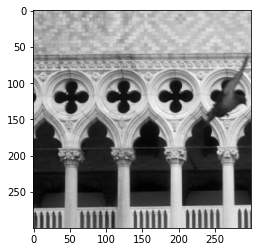

In [4]:
img = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]

plt.show()
plt.imshow(img, cmap='gray')

<Figure size 1440x1440 with 0 Axes>

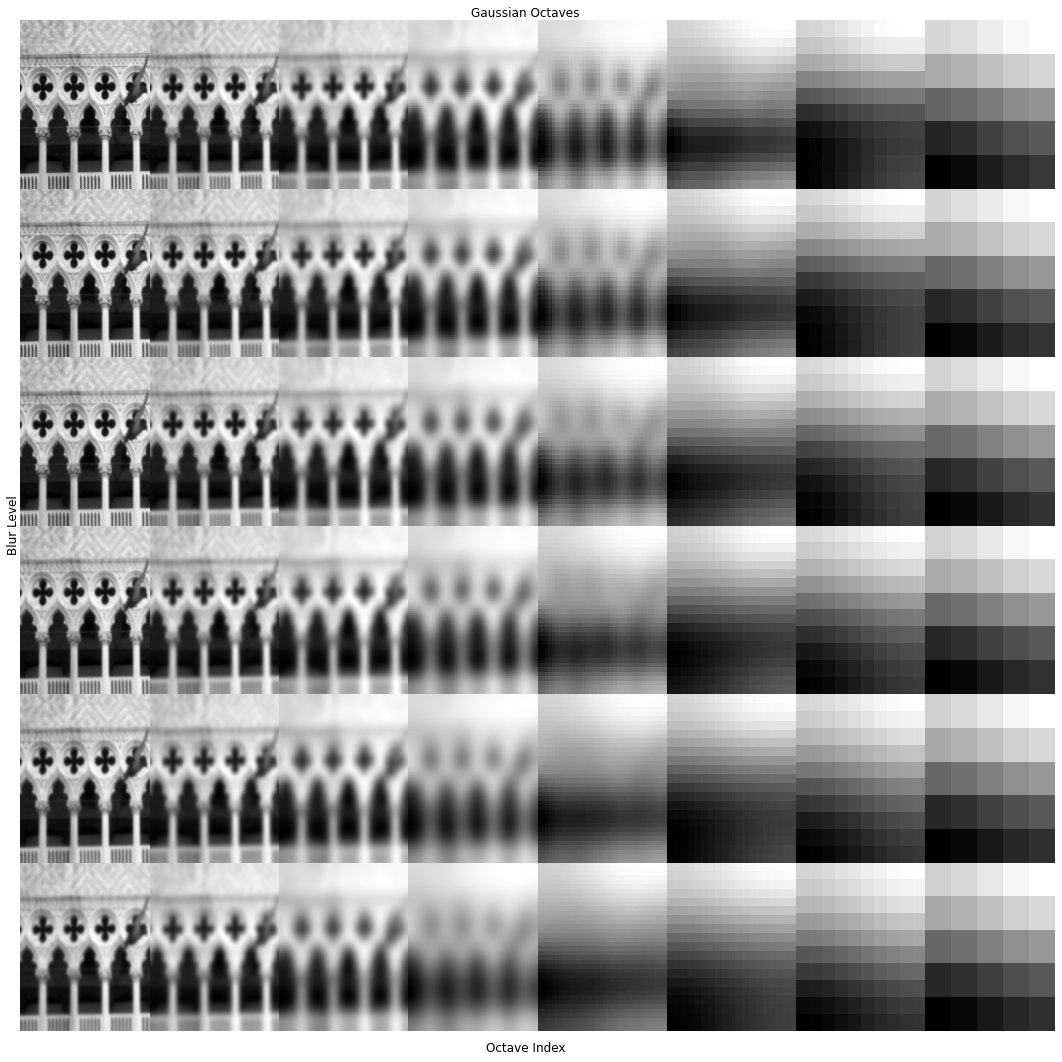

In [6]:
octaves = octaves_lib.build_gaussian_octaves(img)

plt.figure(figsize=(20,20))

nr_cols = len(octaves)      # number of octaves
nr_rows = len(octaves[0])   # number of imgs in octave (at multiple sigma)
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(15, 15), gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)

for col, octave in enumerate(octaves): 
    for row, layer in enumerate(octave):
        axs[row][col].axis('off')
        axs[row][col].imshow(layer, cmap='gray', aspect='auto')
        
fig.suptitle('Gaussian Octaves')
fig.supxlabel('Octave Index')
fig.supylabel('Blur Level')
plt.tight_layout()
plt.show()

# nearly 2 seconds

### 1.2. Diffrence of Gaussian (DOG)
- `Diffrence of Gaussian`: Effiecient to compute edge features by simple image subtraction `(two subsequent imgs at diffrent sigma from the same octave)` which is a fast approximation to Normalized Laplacian of gaussian (NLOG) which require slow convolution computations.
$$ G(x, y, k\sigma) − G(x, y, \sigma) \approx (k − 1)\sigma^2\nabla^2G$$


<p align="center">
  <img src="./images/readme_imgs/dog.png" width="400" height="300"/>
</p>

<Figure size 1440x1440 with 0 Axes>

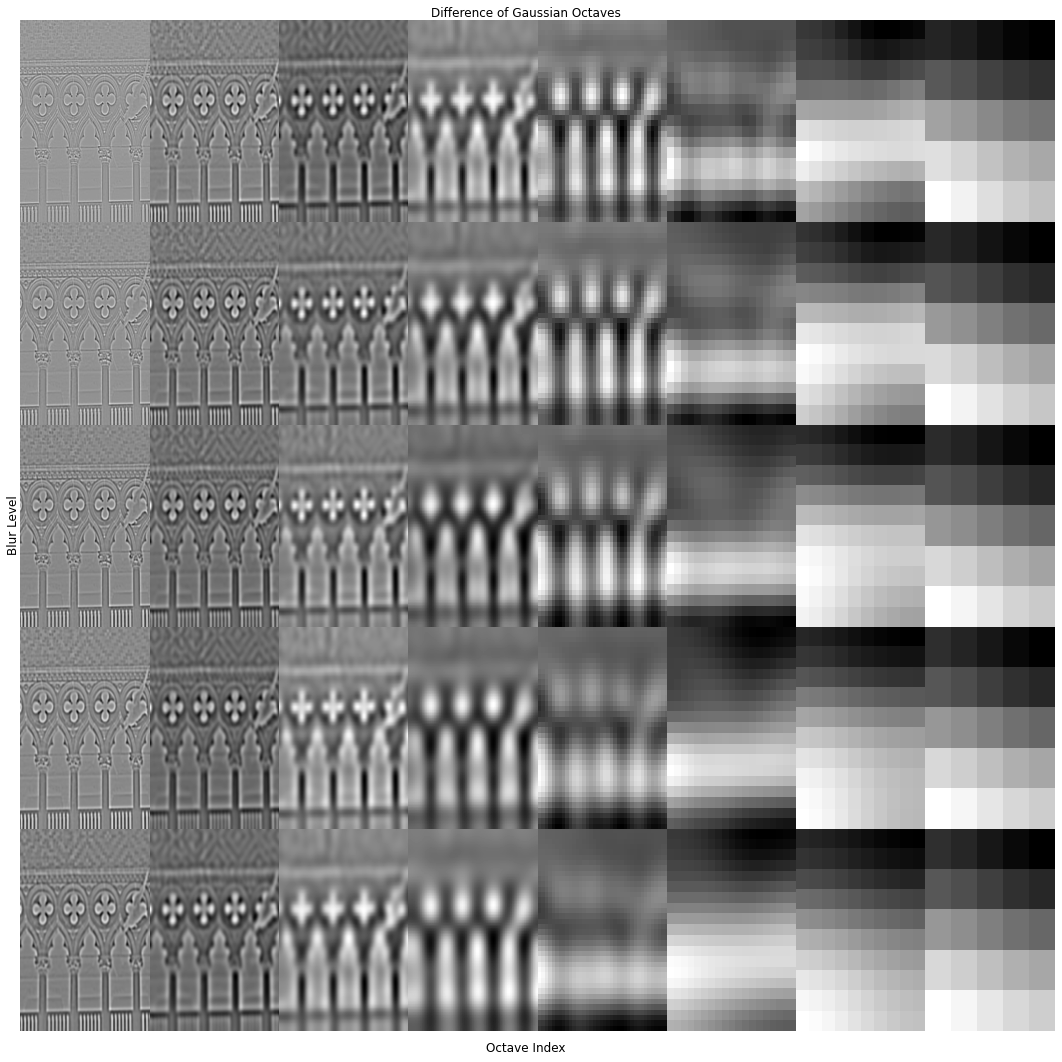

In [8]:
dogs = [octaves_lib.build_dog_octave(octave) for octave in octaves]

plt.figure(figsize=(20,20))

nr_cols = len(dogs) 
nr_rows = len(dogs[0])
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(15, 15), gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)

for col, dog in enumerate(dogs): 
    for row, layer in enumerate(dog):
        axs[row][col].axis('off')
        axs[row][col].imshow(layer, cmap='gray', aspect='auto')
            
fig.supxlabel('Octave Index')
fig.supylabel('Blur Level')
fig.suptitle('Difference of Gaussian Octaves')
plt.tight_layout()
plt.show()

# nearly 1.5 seconds

### 1.3. Local Extremum Detection
- `Local Extremum Detection`: Finds extrema in a DOG octave achieved by subtracting a cell by all it's direct (including diagonal) neighbors, and confirming all differences have the same sign. This coud be visualized as searching for extremum in each 3d cube in each octave.

<p align="center">
  <img src="./images/readme_imgs/max.png" width="300" height="200"/>
</p>

> A lot of extremum will be generated using this step; relying on them will affect the matching stability and hence we will reject points with low contrast neighbourhood and large principal curvature ratio.         

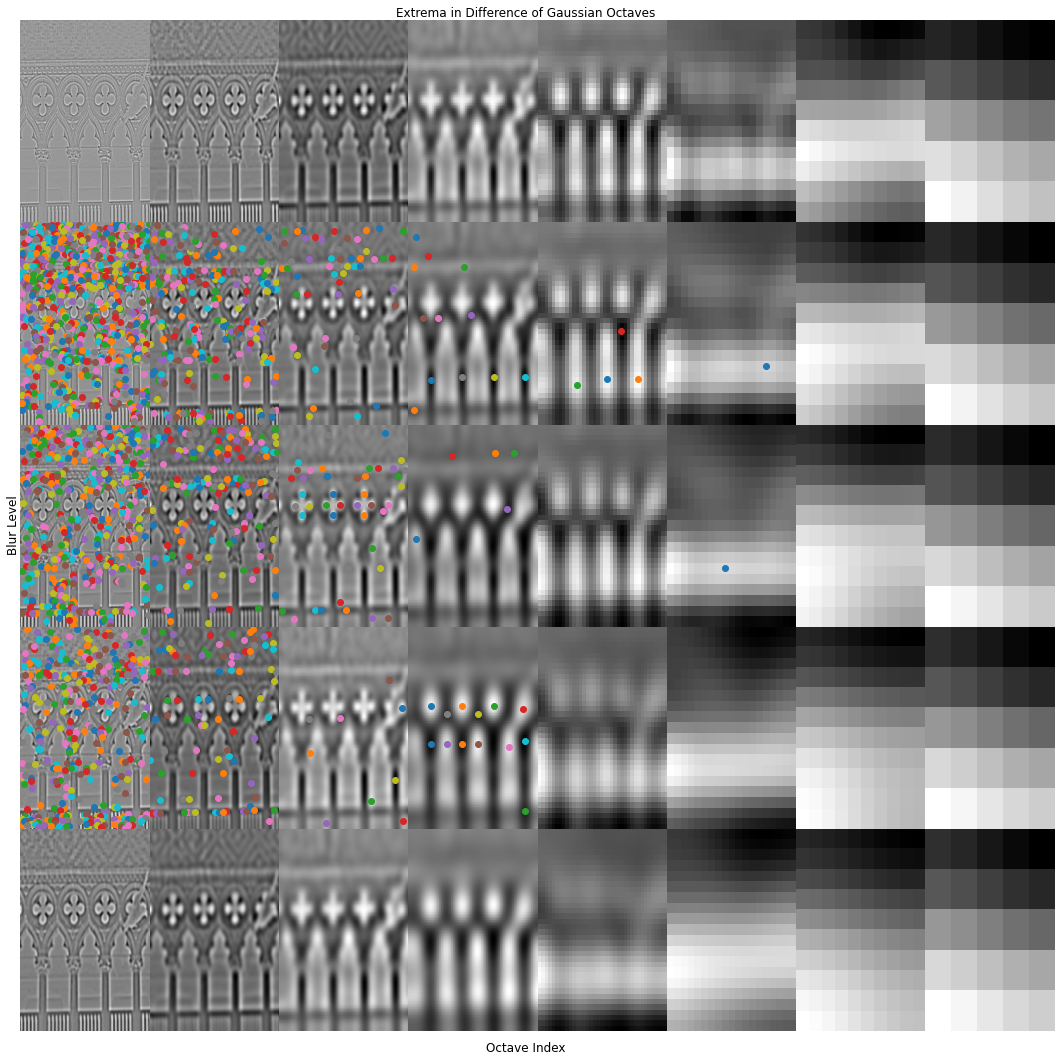

In [9]:
fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(15, 15), gridspec_kw={'wspace':0, 'hspace':0}, squeeze=True)

for col, dog in enumerate(dogs):                          
    extrema = octaves_lib.find_dog_extrema(dog)
                          
    for row, layer in enumerate(dog):                  
        axs[row][col].axis('off')
        axs[row][col].imshow(layer, cmap='gray', aspect='auto')
        
    for s, y, x in extrema.T:
        axs[s][col].scatter(x, y)
                          
fig.supxlabel('Octave Index')
fig.supylabel('Blur Level')
fig.suptitle('Extrema in Difference of Gaussian Octaves')
plt.tight_layout()
plt.show()

## 2. Keypoints (selection from dog extremum)
### 2.1 Accurate Keypoint Localization
The extremum location found in D(sigma, y, x) is not greatly localized as we are only considering a subset of scales. To precicely localize where a keypoint is present we will use quadratic model fit as follows: 

$$ D(X)= D + \frac{\partial D^T}{\partial X} X + \frac{1}{2} X^T \frac{\partial^2 D}{\partial X^2} X$$
$$ \hat{X} =  -\frac{\partial^2 D^-{1}}{\partial X^2} \frac{\partial D}{\partial X} $$ 
- X : is vector of x, y, sigma.
- D : is Diffrence of Gaussian. 
- $ \hat{x} : \textrm{keypoint offset} $
### 2.2 Contrast Threshold
The function value at the extremum, $D(\hat{x})$, is useful for rejecting unstable extrema with low contrast. This can be obtained by substituting in:
$$ D(\hat{X} = D + \frac{1}{2} \frac{\partial D^T}{\partial X} \hat{X} )$$ 

all extrema with a value of $|D(\hat{X})|$ less than 0.03 were
discarded ( assume image pixel values in the range [0,1] ).
### 2.3 Eliminating Edge Response (Principle Curvature Ratio)
A poorly defined peak in the difference-of-Gaussian function will have a large principal curvature across the edge but a small one in the perpendicular direction. The principal curvatures can be computed from a 2x2 Hessian matrix, H, computed at the location and scale of the keypoint:


compute the sum of the eigenvalues from the trace of H and their product from the determinant:
$$ Tr(H)  = D_{xx} + D_{yy}  = \lambda_1 + \lambda_2$$
$$ Det(H) = D_{xx}D_{yy} - (D_{xy})^2 = \lambda_1 \lambda_2 $$
then,
$$ \frac{Tr(H)^2}{Det(H)} < \frac{(r + 1)^2}{r}$$
A value of r = 10, which eliminates
keypoints that have a ratio between the principal curvatures greater than 10.



In [13]:
import keypoints as keypoints_lib

In [39]:
img = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
dog_octave = octaves_lib.build_dog_octave(gauss_octaves[0])
extrema = octaves_lib.find_dog_extrema(dog_octave)
extremum = extrema.T[50]
s, y, x = extremum
derivs, second_derivs = octaves_lib.derivatives(dog_octave)
print(f'An extremum coordinate \n\nscale: {s} \ny: {y} \nx: {x}')

An extremum coordinate 

scale: 1 
y: 41 
x: 196


#### Extremum found within patch od DOG

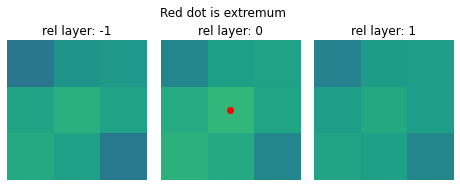

In [40]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'wspace':0.1, 'hspace':0}, squeeze=True)

s, y, x = extremum
patch = dog_octave[s - 1: s + 2, 
                   y - 1: y + 2, 
                   x - 1: x + 2]

for i in range(3):
    axs[i].axis('off')
    axs[i].imshow(patch[i], vmin=0, vmax=0.017)
    axs[i].title.set_text(f'rel layer: {i - 1}')

axs[1].scatter(1,1, c='r')
plt.suptitle('Red dot is extremum')
plt.show()

#### Interpolated Keypoint

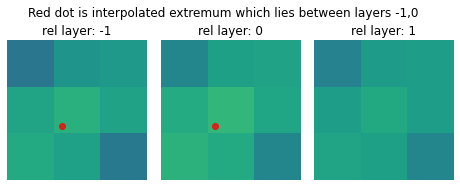

In [41]:
fig, axs = plt.subplots(1, 3, figsize=(8, 3), gridspec_kw={'wspace':0.1, 'hspace':0}, squeeze=True)

success, interpol_coord, interpol_val = keypoints_lib.interpolate(extremum, dog_octave, derivs, second_derivs)
offset = interpol_coord - extremum

for i in range(3):
    axs[i].axis('off')
    axs[i].imshow(patch[i], vmin=0, vmax=0.017)
    axs[i].title.set_text(f'rel layer: {i - 1}')

offset_layer = 0 if offset[0] < 0 else 2

axs[1].scatter(1 + offset[2], 1 + offset[1], c='r', alpha=1 - abs(offset[0]))
axs[offset_layer].scatter(1 + offset[2], 1 + offset[1], c='r', alpha=1-abs(offset[0]))

plt.suptitle('Red dot is interpolated extremum which lies between layers -1,0')
plt.show()

#### Ratio of Keypoints that pass contrast and principal curvatures tests 

In [42]:
valid = 0 
invalid = 0 

for extremum_coord in extrema.T:
    passed = False
    if abs(dog_octave[tuple(extremum_coord)]) > const.coarse_magnitude_thresh:
        success, extremum_coord, extremum_val = keypoints_lib.interpolate(extremum_coord, dog_octave, derivs, second_derivs)
        if success and abs(extremum_val) > const.magnitude_thresh:
            s, y, x = extremum_coord.round().astype(int)
            if keypoints_lib.pass_edge_test(second_derivs[:, s, y, x]):
                valid += 1
                passed = True
    if passed == False: 
        invalid += 1
        
print(f'Pecentage of valid keypoints (pass contrast and curvature tests): {valid / (valid + invalid) * 100:.2f}%')

Pecentage of valid keypoints (pass contrast and curvature tests): 31.72%


## 3. Keypoint Orientation
the orientation of the keypoint is importan as it is used to translate the local neighbourhood region with refrence to its principal orientation hence provide `orientation invarient` features.

In [43]:
import matplotlib.patches as patches
import reference_orientation as reference_lib

In [48]:
img = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]
octave_idx = 2
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
gauss_octave = gauss_octaves[octave_idx]
dog_octave = octaves_lib.build_dog_octave(gauss_octave)
extrema = octaves_lib.find_dog_extrema(dog_octave)
keypoint_coords = keypoints_lib.find_keypoints(extrema, dog_octave)
coord = keypoint_coords[0]
print(f'Octave {octave_idx} has {len(keypoint_coords)} keypoints')

Octave 2 has 52 keypoints


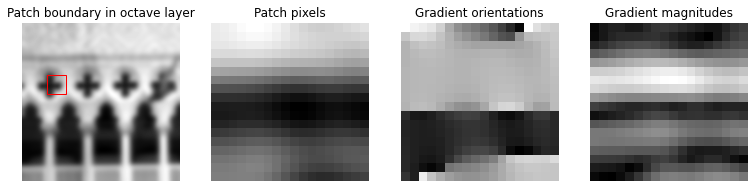

In [61]:
magnitudes, orientations = reference_lib.gradients(gauss_octave)
orientations_bins = reference_lib.orientation_to_bin_idx(orientations)
octave_shape = gauss_octave.shape
pixel_dist = const.min_pixel_dist * (2 ** octave_idx)

s, y, x = coord.round().astype(int)
absolute_coord = np.array([x * pixel_dist, y * pixel_dist])
sigma = octaves_lib.absolute_sigma(octave_idx, s)
patch_width = reference_lib.reference_patch_width(octave_idx, sigma)
patch_with_half = round(patch_width / 2)

if reference_lib.patch_in_frame(coord, patch_with_half, octave_shape):
    patch = gauss_octave[s,
                         y - patch_with_half: y + patch_with_half,
                         x - patch_with_half: x + patch_with_half]
    orientation_patch = orientations[s,
                                     y - patch_with_half: y + patch_with_half,
                                     x - patch_with_half: x + patch_with_half]
    orientation_patch_bins = orientations_bins[s,
                                               y - patch_with_half: y + patch_with_half,
                                               x - patch_with_half: x + patch_with_half]
    magnitude_patch = magnitudes[s,
                                 y - patch_with_half: y + patch_with_half,
                                 x - patch_with_half: x + patch_with_half]


fig, axs = plt.subplots(1, 4, figsize=(13, 4))
rect = patches.Rectangle(coord[1:] - patch_with_half, patch_width, patch_width, linewidth=1, edgecolor='r', facecolor='none')

axs[0].imshow(gauss_octave[s], cmap='gray')
axs[0].add_patch(rect)
axs[1].imshow(patch, cmap='gray')
axs[2].imshow(orientation_patch, cmap='gray')
axs[3].imshow(magnitude_patch, cmap='gray')
axs[0].title.set_text('Patch boundary in octave layer')
axs[1].title.set_text('Patch pixels')
axs[2].title.set_text('Gradient orientations')
axs[3].title.set_text('Gradient magnitudes')
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')
axs[3].axis('off')

plt.show()

#### Gradient Direction
it is used to weight the magnitude of each orientation in generating the histogram.

Text(0.5, 1.0, 'Image gradients')

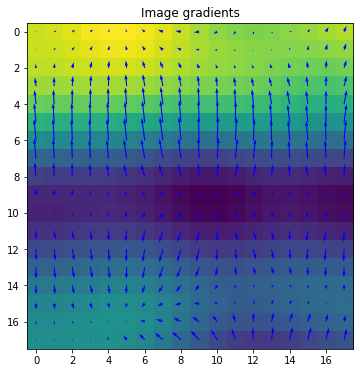

In [53]:
rows, cols = patch.shape
nr_pixels = rows * cols
y_idxs = np.arange(rows)
x_idxs = np.arange(cols)
xs, ys = np.meshgrid(x_idxs, y_idxs)

length = magnitude_patch.flatten()

v_xs = length
v_ys = [0] * len(v_xs)
# Angles are inverted, because the y axis is flipped by imshow, meaning that 
# arrows that should point down point up. The minus operator solves this axis inversion. 
angles = np.rad2deg(-orientation_patch).flatten()
plt.figure(figsize=(6, 6))
plt.imshow(patch)
plt.quiver(xs, ys, v_xs, v_ys, angles=angles, color='b')
plt.title('Image gradients')

#### Orientation Histogram (36 bins) Maxima
if there is another orientaion that lie within 80% of the maximum a new key point is generated similar to thr original, but with another orientation. 

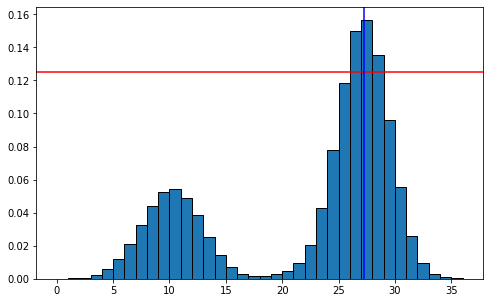

The maximum bin at index 26.74 represents a reference orientation of 4.67 radians or 267.40 degrees


In [54]:
patch_shape = magnitude_patch.shape
center_offset = [coord[1] - y, coord[2] - x]
weights = reference_lib.weighting_matrix(center_offset, patch_shape, octave_idx, sigma, const.reference_locality)
contribution = weights * magnitude_patch
hist, bin_edges = np.histogram(orientation_patch_bins, bins=const.nr_bins, range=(0, const.nr_bins), weights=contribution)
hist = reference_lib.smoothen_histogram(hist)
dominant_orientations = reference_lib.find_histogram_peaks(hist)


fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
ax.axhline(y=0.8 * np.max(hist), color='r', linestyle='-')

max_bins = list()
for maximum in dominant_orientations:
    loc = (maximum / (2 * np.pi)) * const.nr_bins
    max_bins.append(loc)
    ax.axvline(x=loc + 0.5, color='b', linestyle='-')

plt.show()

print(f'The maximum bin at index {loc:.2f} represents a reference orientation of {maximum:.2f} radians or {np.rad2deg(maximum):.2f} degrees') 


## 4. Descriptor Representation
 A keypoint descriptor is created by first computing the gradient magnitude and orientation at each image sample point in a region around the keypoint location. 

These are weighted by a Gaussian window, indicated by the overlaid circle. These samples are then accumulated into orientation histograms (8 bins) summarizing the contents over 4x4 subregions. [4x4x8 = 128 element feature vector]

<p align="center">
  <img src="./images/readme_imgs/descriptor.png" width="500" height="200"/>
</p>

A goof descriptor used in matching should account for misregistration, distortion, noise and illumination changes. Simple correlation of image patches is highly sensitive to changes that cause misregistration of samples, such as affine or 3D viewpoint change or non-rigid deformations. 

To solve this problems we could mimic the complex neurons in primary visual cortex. These complex neurons respond to a gradient at a particular
orientation and spatial frequency, but the location of the gradient on the retina is allowed to shift over a small receptive field rather than being precisely localized.

Mimicing Neurons could be achieved by 3 steps:
### 4.1. A Gaussian weighting function (solve misregistration, distortion)
The purpose of this Circular Gaussian window is to
- Avoid sudden changes in the descriptor with small changes in the position of the window
- Give less emphasis to gradients that are far from the center of the descriptor, as these `edges are most affected by misregistration errors`.
### 4.2. (4 x 4 x 8 bin) histograms concatenation (solve distortion)
using only 8 bins allows for significant shift in gradient positions by creating orientation histograms over 4x4 sample regions. A gradient sample can shift up to 4 sample positions while still contributing to the same histogram, thereby achieving the objective of allowing for larger `local positional shifts`.
### 4.3 Normalized Vector (solve for illumination changes)
A change in image contrast in which each pixel value is multiplied by a constant will multiply gradients by the same constant, so this contrast change will be canceled by vector normalization.

A brightness change in which a constant
is added to each image pixel will not affect the gradient values, as they are computed from pixel differences. Therefore, the descriptor is `invariant to affine changes in illumination`.

In [62]:
import descriptor as descriptor_lib

In [67]:
img = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img = img[0:300, 100:400]

octave_idx =2
gauss_octaves = octaves_lib.build_gaussian_octaves(img)
gauss_octave = gauss_octaves[octave_idx]
dog_octave = octaves_lib.build_dog_octave(gauss_octave)
extrema = octaves_lib.find_dog_extrema(dog_octave)
keypoint_coords = keypoints_lib.find_keypoints(extrema, dog_octave)
keypoints = reference_lib.assign_reference_orientations(keypoint_coords, gauss_octave, octave_idx)
keypoint = keypoints[8]

magnitudes, orientations = reference_lib.gradients(gauss_octave)
coord = keypoint.coordinate
sigma = keypoint.sigma
shape = gauss_octave.shape
s, y, x = coord.round().astype(int)

pixel_dist = octaves_lib.pixel_dist_in_octave(octave_idx)
max_width = (np.sqrt(2) * const.descriptor_locality * sigma) / pixel_dist
max_width = max_width.round().astype(int)

in_frame = descriptor_lib.patch_in_frame(coord, max_width, shape)
print(f'This keypoint is in frame: {in_frame}')

This keypoint is in frame: True


#### Gaussian Weighting 

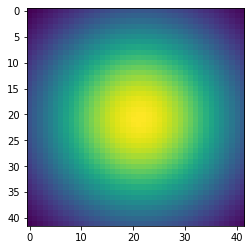

In [69]:
orientation_patch = orientations[s,
                                 y - max_width: y + max_width,
                                 x - max_width: x + max_width]
magnitude_patch = magnitudes[s,
                             y - max_width: y + max_width,
                             x - max_width: x + max_width]
patch_shape = magnitude_patch.shape
center_offset = [coord[1] - y, coord[2] - x]
rel_patch_coords = descriptor_lib.relative_patch_coordinates(center_offset, patch_shape, pixel_dist, sigma, keypoint.orientation)

magnitude_patch = descriptor_lib.mask_outliers(magnitude_patch, rel_patch_coords, const.descriptor_locality)
orientation_patch = (orientation_patch - keypoint.orientation) % (2 * np.pi)
weights = descriptor_lib.weighting_matrix(center_offset, patch_shape, octave_idx, sigma, const.descriptor_locality)
plt.imshow(weights)

#### Descriptor Patch

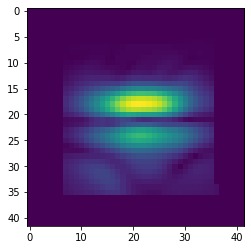

In [81]:

magnitude_patch = magnitude_patch * weights
plt.imshow(magnitude_patch)
coords_rel_to_hists = rel_patch_coords[None] - descriptor_lib.histogram_centers[..., None, None]
hists_magnitude_patch = descriptor_lib.mask_outliers(magnitude_patch[None], coords_rel_to_hists, const.inter_hist_dist, 1)

In [79]:
hists_magnitude_patch = descriptor_lib.interpolate_2d_grid_contribution(hists_magnitude_patch, coords_rel_to_hists)
hists = descriptor_lib.interpolate_1d_hist_contribution(hists_magnitude_patch, orientation_patch)
sift_feature = descriptor_lib.normalize_sift_feature(hists.ravel())

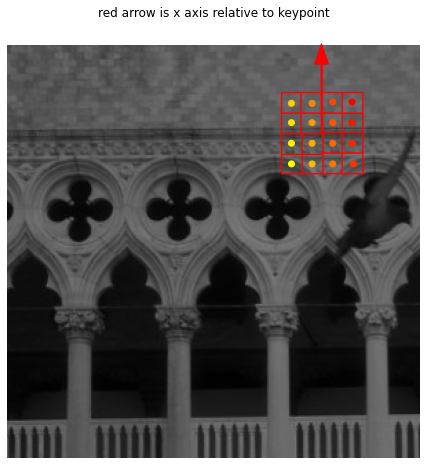

The red arrow represtns a rotation of 269.5350723845689 degrees.


In [80]:
abs_coord = keypoint.absolute_coordinate[1:][::-1]
coord = keypoint.coordinate
sigma = keypoint.sigma
shape = gauss_octave.shape
s, y, x = coord.round().astype(int)
center_offset = [coord[1] - y, coord[2] - x]
pixel_dist = octaves_lib.pixel_dist_in_octave(octave_idx)
width = const.descriptor_locality * sigma
theta = keypoint.orientation
c, s = np.cos(theta), np.sin(theta)
rot_mat = np.array(((c, -s), (s, c)))
arrow = np.matmul(rot_mat, np.array([1, 0])) * 50

hist_centers = descriptor_lib.histogram_centers.T
hist_centers = hist_centers * sigma 
hist_centers = np.matmul(rot_mat, hist_centers)
hist_centers = (hist_centers + abs_coord[:,None]).round().astype(int)
color = (1, 0, 0)

darkened = cv2.addWeighted(img, 0.5, np.zeros(img.shape, img.dtype),0,0)
col_img =  cv2.cvtColor(darkened, cv2.COLOR_GRAY2RGB)

# Horizontal lines
for i in range(5):
    offset = np.array([0, width/2]) * i
    l = np.array([-width, -width]) + offset
    r = np.array([width, -width]) + offset
    l = (np.matmul(rot_mat, l) + abs_coord).round().astype(int)
    r = (np.matmul(rot_mat, r) + abs_coord).round().astype(int) 
    col_img = cv2.line(col_img, l, r, color=color, thickness=1)
    
# Vertical lines
for i in range(5): 
    offset = np.array([width/2, 0]) * i
    t = np.array([-width, -width]) + offset
    b = np.array([-width, width]) + offset
    t = (np.matmul(rot_mat, t) + abs_coord).round().astype(int)
    b = (np.matmul(rot_mat, b) + abs_coord).round().astype(int) 
    col_img = cv2.line(col_img, t, b, color=color, thickness=1)

plt.figure(figsize=(8, 8))
plt.imshow(col_img)
plt.axis('off')
plt.title('red arrow is x axis relative to keypoint')
xs, ys = hist_centers
plt.scatter(xs, ys, c=[x for x in range(len(xs))], cmap='autumn_r')
plt.arrow(abs_coord[0], abs_coord[1], arrow[0], arrow[1], color='red', width=1, head_width=10)
plt.show()

print(f'The red arrow represtns a rotation of {np.rad2deg(keypoint.orientation)} degrees.')

#### Histogram of each sub-region

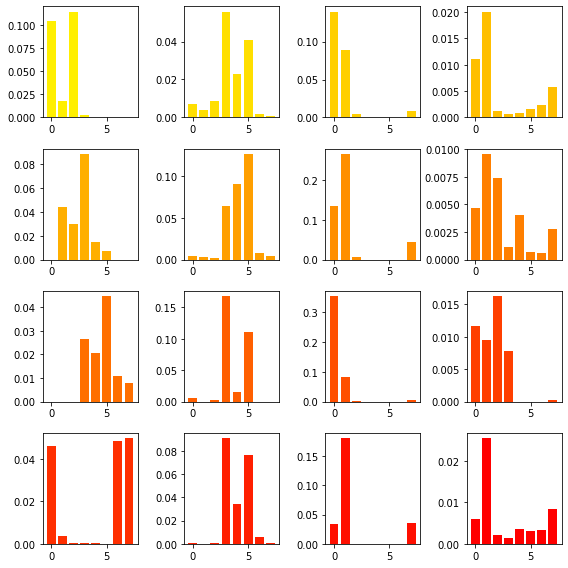

In [76]:
cmap = plt.cm.get_cmap('autumn_r')
fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for idx, hist in enumerate(hists): 
    row = idx // 4
    col = idx % 4
    color = cmap((idx + 1) / len(hists))
    axs[row, col].bar(list(range(const.nr_descriptor_bins)), hist, color=color)

plt.tight_layout()
plt.show()

#### Concatenation of 4x4 sub-regions histogram to form a  `descriptor feature vector`

<BarContainer object of 128 artists>

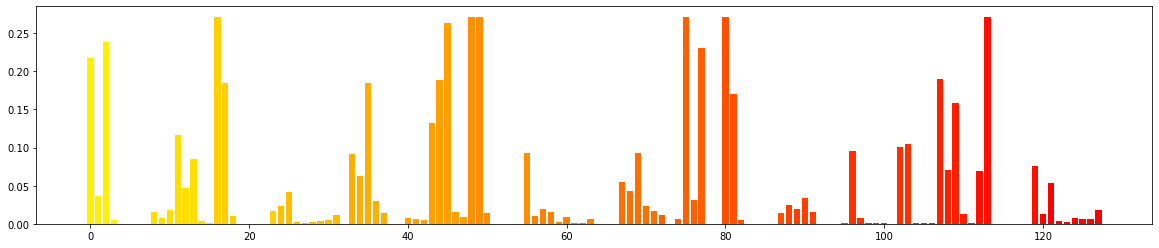

In [77]:
colors = [cmap((idx+1) / len(hists)) for idx in range(16)]
colors = np.repeat(colors, const.nr_descriptor_bins, axis=0)
plt.figure(figsize=(20, 4))
plt.bar(range(len(sift_feature)), sift_feature, color=colors)


## 5. Matching
To match features of two images we simply search for each descriptor in image1 to find the neareast neighbour from the image2 descriptors by using sum of squared diffrences (SSD).

In [83]:
import match as match_lib
import sift as sift_lib

The matching time depends on images size and content (number of keypoints)
from our tests  
### Matching Time

|img | unvectorized | vectorized|
|----------------|-----------|----------|
|box |   148 s  |  14 s|
|london|  269s | 54 s|
|san_marco|--- | 4 m 14 s |


### test on hard imgs 
- diffrent 3d views
- diffrent scales
- occluded objects 

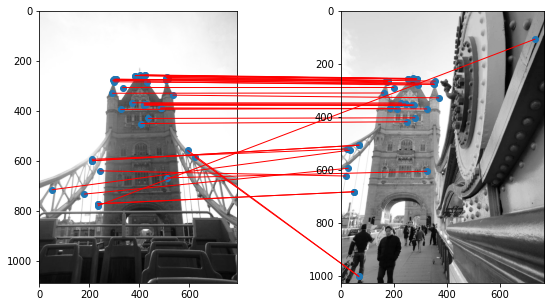

In [87]:
img1 = cv2.imread('../images/london_bridge_1.jpg', flags=cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/london_bridge_2.jpg', flags=cv2.IMREAD_GRAYSCALE)

img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

features1 = sift_lib.detect_sift_features(img1)
features2 = sift_lib.detect_sift_features(img2)
matches = match_lib.match_sift_features(features1, features2)
match_lib.visualize_matches(matches, img1, img2)

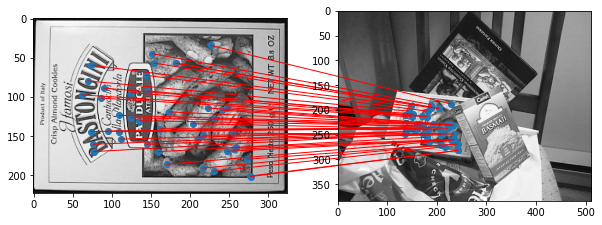

In [88]:
img1 = cv2.imread('../images/box.png', flags=cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/box_in_scene.png', flags=cv2.IMREAD_GRAYSCALE)

img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

features1 = sift_lib.detect_sift_features(img1)
features2 = sift_lib.detect_sift_features(img2)
matches = match_lib.match_sift_features(features1, features2)
match_lib.visualize_matches(matches, img1, img2)


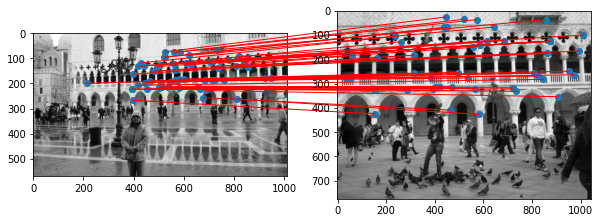

In [89]:

img1 = cv2.imread('../images/piazza_san_marco_1.jpg', flags=cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)


img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

features1 = sift_lib.detect_sift_features(img1)
features2 = sift_lib.detect_sift_features(img2)
matches = match_lib.match_sift_features(features1, features2)
match_lib.visualize_matches(matches, img1, img2)


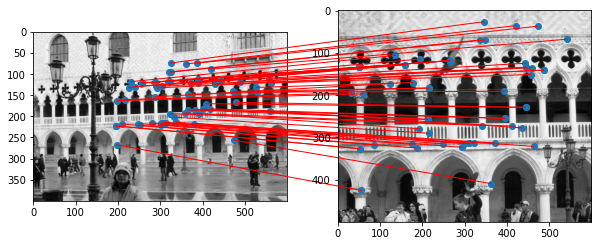

In [95]:

img1 = cv2.imread('../images/piazza_san_marco_1.jpg', flags=cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('../images/piazza_san_marco_2.jpg', flags=cv2.IMREAD_GRAYSCALE)
img1 = img1[0:400, 200:800 ]
img2 = img2[0:500, 100:700]

img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

# # plt.imshow(img1)
# plt.imshow(img2)

features1 = sift_lib.detect_sift_features(img1)
features2 = sift_lib.detect_sift_features(img2)
matches = match_lib.match_sift_features(features1, features2)
match_lib.visualize_matches(matches, img1, img2)




# Harris corner Detection

In [4]:
import cv2
import matplotlib.pyplot as plt
from find_harris_corners import harris


Detecting Corners Started!
Detecting Corners Complete!


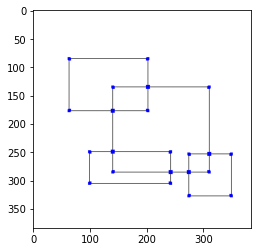

In [5]:
img1 = cv2.imread('../images/ex1.png')
corner = harris(img1)
plt.imshow(corner)

Detecting Corners Started!
Detecting Corners Complete!


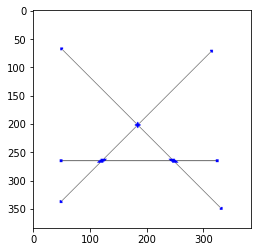

In [14]:
img1 = cv2.imread('../images/ex3.png')
corner = harris(img1)
plt.imshow(corner)